In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt 
# 데이터 로드
data =  pd.read_csv('./../../Fed1_dataset/Interest_rate_prediction.csv') 
df = data.copy()

# DATE 열을 datetime 형식으로 변환 및 인덱스 설정
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# 숫자형 데이터만 선택 (LSTM에 입력하기 위해)
numeric_df = df.select_dtypes(include=[np.number])

# 목표 변수 설정 (예: DFEDTARU)
target_column = 'DFEDTARU'

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)


In [3]:
sequence_length = 60  # 60일의 데이터를 사용하여 다음 날을 예측
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, numeric_df.columns.get_loc(target_column)])

X, y = np.array(X), np.array(y)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


C:\Users\kimjuseong\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0370 - val_loss: 0.8062
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0313 - val_loss: 0.4596
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0173 - val_loss: 0.3560
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0114 - val_loss: 0.4672
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0110 - val_loss: 0.3599
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0057 - val_loss: 0.2444
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0045 - val_loss: 0.2326
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037 - val_loss: 0.1960
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0051 - val_loss: 0.1737
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0045 - val_loss: 0.2137
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0030 - val_loss: 0.2023
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036 - val_loss: 0.2086
Epoch 13/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


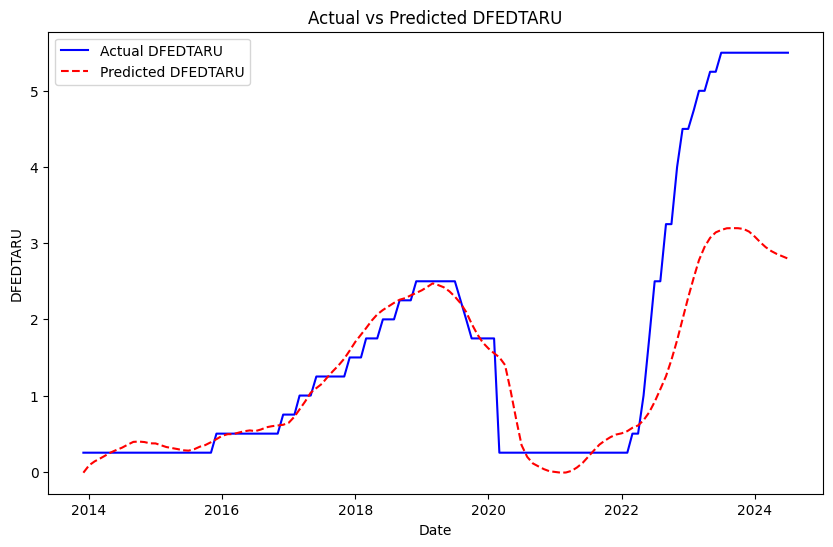

In [5]:
# 예측 수행
predicted_values = model.predict(X)

# 예측값을 원래 스케일로 역변환
predicted_values = scaler.inverse_transform(np.concatenate([predicted_values, np.zeros((predicted_values.shape[0], numeric_df.shape[1] - 1))], axis=1))[:, 0]

# 실제값 복원
actual_values = scaler.inverse_transform(np.concatenate([y.reshape(-1, 1), np.zeros((y.shape[0], numeric_df.shape[1] - 1))], axis=1))[:, 0]

# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(predicted_values):], actual_values, color='blue', label='Actual DFEDTARU')
plt.plot(df.index[-len(predicted_values):], predicted_values, color='red', linestyle='--', label='Predicted DFEDTARU')
plt.title('Actual vs Predicted DFEDTARU')
plt.xlabel('Date')
plt.ylabel('DFEDTARU')
plt.legend()
plt.show()
